In [1]:
import os
import pathlib

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
from notebook_init_utils import bandicoot_check, init_notebook
from pycytominer import feature_select, normalize

root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

In [2]:
patients = [
    "NF0037_T1-Z-1",
    "NF0037_T1-Z-0.5",
    "NF0037_T1-Z-0.2",
    # "NF0037_T1-Z-0.1",
]

In [3]:
organoid_paths = [
    pathlib.Path(
        f"{image_base_dir}/data/{patient}/image_based_profiles/2.annotated_profiles/organoid_anno.parquet"
    )
    for patient in patients
]

sc_paths = [
    pathlib.Path(
        f"{image_base_dir}/data/{patient}/image_based_profiles/2.annotated_profiles/sc_anno.parquet"
    )
    for patient in patients
]

figure_dir = pathlib.Path(
    f"{root_dir}/7.technical_analysis/figures/zstep_profile_analysis"
).resolve()
figure_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Merge organoid profiles
organoid_combined_dfs = pd.concat(
    [pd.read_parquet(path) for path in organoid_paths],
    ignore_index=True,
)

# merge sc profiles
sc_combined_dfs = pd.concat(
    [pd.read_parquet(path) for path in sc_paths],
    ignore_index=True,
)

In [5]:
organoid_combined_dfs["Metadata_zstep"] = (
    organoid_combined_dfs["Metadata_tumor"].str.split("Z-").str[1]
)
sc_combined_dfs["Metadata_zstep"] = (
    sc_combined_dfs["Metadata_tumor"].str.split("Z-").str[1]
)
organoid_combined_dfs.head()

,Metadata_patient_tumor,Metadata_object_id,Metadata_unit,Metadata_dose,Metadata_treatment,Metadata_image_set,Metadata_Well,Metadata_single_cell_count,Area.Size.Shape_Organoid_VOLUME,Area.Size.Shape_Organoid_CENTER.X,...,Texture_Organoid_Mito_Sum.Average_256.3,Texture_Organoid_Mito_Sum.Entropy_256.3,Texture_Organoid_Mito_Sum.Variance_256.3,Texture_Organoid_Mito_Variance_256.3,Metadata_Target,Metadata_Class,Metadata_Therapeutic_Categories,Metadata_patient,Metadata_tumor,Metadata_zstep
0,NF0037_T1-Z-1,1,%,1,DMSO 1%,F4-2,F4,NaN,122.0,1353.795044,...,0.000377,0.000045,0.076721,0.035127,None,None,None,NF0037,T1-Z-1,1
1,NF0037_T1-Z-1,2,%,1,DMSO 1%,F4-2,F4,NaN,889059.0,820.129333,...,0.859732,0.137404,64.010783,24.967784,None,None,None,NF0037,T1-Z-1,1
2,NF0037_T1-Z-1,24,%,1,DMSO 1%,F4-2,F4,NaN,1231610.0,948.151978,...,1.338529,0.179836,111.443630,43.500075,None,None,None,NF0037,T1-Z-1,1
3,NF0037_T1-Z-1,27,%,1,DMSO 1%,F4-2,F4,NaN,2130325.0,915.766785,...,2.094138,0.283222,155.788455,61.056217,None,None,None,NF0037,T1-Z-1,1
4,NF0037_T1-Z-1,29,%,1,DMSO 1%,F4-2,F4,NaN,1663760.0,883.124084,...,1.627180,0.229967,121.230278,47.403461,None,None,None,NF0037,T1-Z-1,1


In [6]:
organoid_metadata_columns = [
    x for x in organoid_combined_dfs.columns if "Metadata" in x
]

organoid_metadata_columns += [
    "Area.Size.Shape_Organoid_CENTER.X",
    "Area.Size.Shape_Organoid_CENTER.Y",
    "Area.Size.Shape_Organoid_CENTER.Z",
]
organoid_features_columns = [
    col for col in organoid_combined_dfs.columns if col not in organoid_metadata_columns
]

# sc metadata and features
sc_metadata_columns = [x for x in sc_combined_dfs.columns if "Metadata" in x]

sc_metadata_columns += [
    "Area.Size.Shape_Cell_CENTER.X",
    "Area.Size.Shape_Cell_CENTER.Y",
    "Area.Size.Shape_Cell_CENTER.Z",
    "Area.Size.Shape_Nuclei_CENTER.X",
    "Area.Size.Shape_Nuclei_CENTER.Y",
    "Area.Size.Shape_Nuclei_CENTER.Z",
    "Area.Size.Shape_Cytoplasm_CENTER.X",
    "Area.Size.Shape_Cytoplasm_CENTER.Y",
    "Area.Size.Shape_Cytoplasm_CENTER.Z",
]
sc_features_columns = [
    col for col in sc_combined_dfs.columns if col not in sc_metadata_columns
]

In [7]:
# normalize the data
organoid_normalized_profiles = normalize(
    organoid_combined_dfs,
    features=organoid_features_columns,
    meta_features=organoid_metadata_columns,
    method="standardize",
    samples="Metadata_zstep == '1'",
)
organoid_fs_df = feature_select(
    organoid_normalized_profiles,
    features=organoid_features_columns,
)

# normalize the data sc
sc_normalized_profiles = normalize(
    sc_combined_dfs,
    features=sc_features_columns,
    meta_features=sc_metadata_columns,
    method="standardize",
    samples="Metadata_zstep == '1'",
)
sc_fs_df = feature_select(
    sc_normalized_profiles,
    features=sc_features_columns,
)

In [8]:
organoid_metadata_columns = [x for x in organoid_fs_df.columns if "Metadata" in x]

organoid_metadata_columns += [
    "Area.Size.Shape_Organoid_CENTER.X",
    "Area.Size.Shape_Organoid_CENTER.Y",
    "Area.Size.Shape_Organoid_CENTER.Z",
]
organoid_features_columns = [
    col for col in organoid_fs_df.columns if col not in organoid_metadata_columns
]

# sc metadata and features
sc_metadata_columns = [x for x in sc_fs_df.columns if "Metadata" in x]
sc_metadata_columns += [
    "Area.Size.Shape_Cell_CENTER.X",
    "Area.Size.Shape_Cell_CENTER.Y",
    "Area.Size.Shape_Cell_CENTER.Z",
    "Area.Size.Shape_Nuclei_CENTER.X",
    "Area.Size.Shape_Nuclei_CENTER.Y",
    "Area.Size.Shape_Nuclei_CENTER.Z",
    "Area.Size.Shape_Cytoplasm_CENTER.X",
    "Area.Size.Shape_Cytoplasm_CENTER.Y",
    "Area.Size.Shape_Cytoplasm_CENTER.Z",
]
sc_features_columns = [
    col for col in sc_fs_df.columns if col not in sc_metadata_columns
]

In [9]:
# save the normalized profiles
organoid_normalized_output_path = pathlib.Path(
    f"{root_dir}/7.technical_analysis/processed_data/organoid_fs_zstep_profiles.parquet"
).resolve()
sc_normalized_output_path = pathlib.Path(
    f"{root_dir}/7.technical_analysis/processed_data/sc_fs_zstep_profiles.parquet"
).resolve()
organoid_normalized_output_path.parent.mkdir(parents=True, exist_ok=True)
# replace na with 0
organoid_fs_df = organoid_fs_df.fillna(0)
organoid_fs_df.to_parquet(organoid_normalized_output_path, index=False)
sc_normalized_output_path.parent.mkdir(parents=True, exist_ok=True)
sc_fs_df = sc_fs_df.fillna(0)
sc_fs_df.to_parquet(sc_normalized_output_path, index=False)

/tmp/ipykernel_64217/800380886.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  organoid_fs_df = organoid_fs_df.fillna(0)
/tmp/ipykernel_64217/800380886.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sc_fs_df = sc_fs_df.fillna(0)


/home/lippincm/miniforge3/envs/nf1_image_based_profiling_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_64217/1543060923.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(ordered_zsteps))


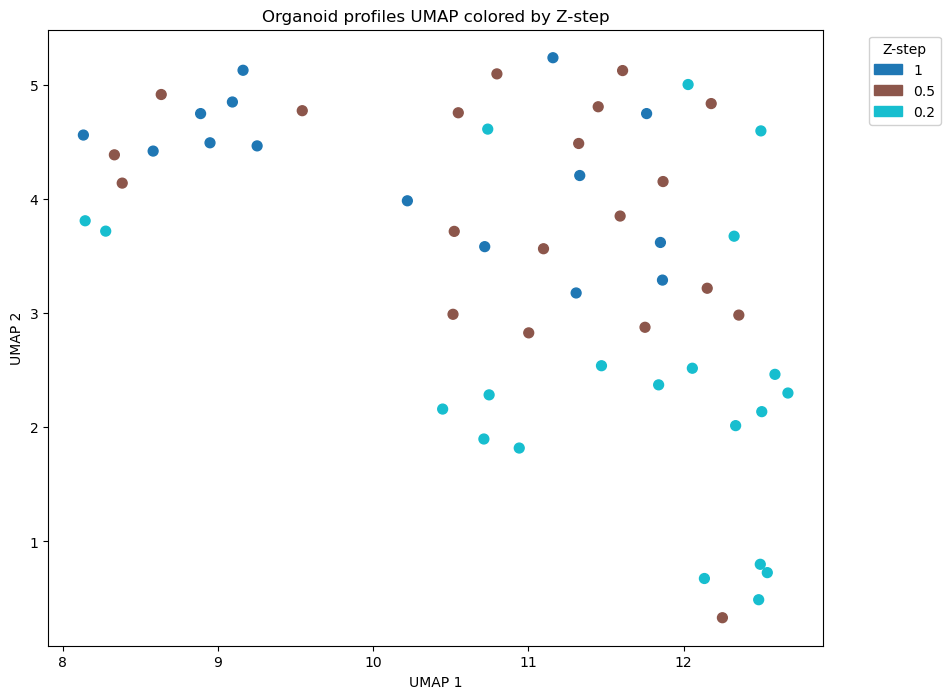

In [10]:
reducer = umap.UMAP(random_state=0)
embedding = reducer.fit_transform(organoid_fs_df[organoid_features_columns].values)

zstep = organoid_fs_df["Metadata_zstep"].astype(str).values
unique_zsteps = organoid_fs_df["Metadata_zstep"].astype(str).unique()
# map z-step values to numeric codes for coloring, ordered 1, 0.5, 0.2
ordered_zsteps = sorted(unique_zsteps, key=lambda x: float(x), reverse=True)
zstep_to_color = {z: i for i, z in enumerate(ordered_zsteps)}
zstep_numeric = np.array([zstep_to_color[z] for z in zstep])

cmap = plt.cm.get_cmap("tab10", len(ordered_zsteps))

fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=50,
    c=zstep_numeric,
    cmap=cmap,
    alpha=1.0,
    rasterized=True,
)

# create legend with z-step labels ordered
legend_handles = [
    mpatches.Patch(color=cmap(i), label=z) for z, i in zstep_to_color.items()
]
ax.legend(
    handles=legend_handles,
    title="Z-step",
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
    framealpha=0.9,
)

ax.set_title("Organoid profiles UMAP colored by Z-step")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
plt.savefig(figure_dir / "organoid_zstep_umap.png", dpi=600, bbox_inches="tight")
plt.show()

/home/lippincm/miniforge3/envs/nf1_image_based_profiling_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_64217/3737547265.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(ordered_zsteps))


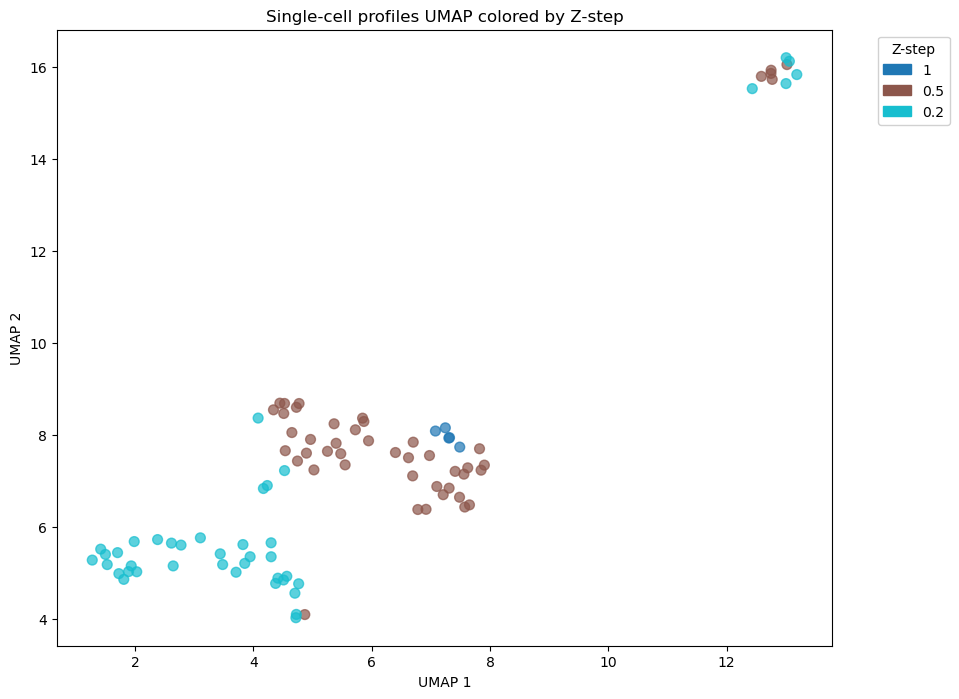

In [11]:
reducer = umap.UMAP(random_state=0)
embedding = reducer.fit_transform(sc_fs_df[sc_features_columns].values)

zstep = sc_fs_df["Metadata_zstep"].astype(str).values
unique_zsteps = sc_fs_df["Metadata_zstep"].astype(str).unique()
# map z-step values to numeric codes for coloring, ordered 1, 0.5, 0.2
ordered_zsteps = sorted(unique_zsteps, key=lambda x: float(x), reverse=True)
zstep_to_color = {z: i for i, z in enumerate(ordered_zsteps)}
zstep_numeric = np.array([zstep_to_color[z] for z in zstep])

cmap = plt.cm.get_cmap("tab10", len(ordered_zsteps))

fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=50,
    c=zstep_numeric,
    cmap=cmap,
    alpha=0.7,
    rasterized=True,
)

# create legend with z-step labels ordered
legend_handles = [
    mpatches.Patch(color=cmap(i), label=z) for z, i in zstep_to_color.items()
]
ax.legend(
    handles=legend_handles,
    title="Z-step",
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
    framealpha=0.9,
)

ax.set_title("Single-cell profiles UMAP colored by Z-step")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
plt.savefig(figure_dir / "sc_zstep_umap.png", dpi=600, bbox_inches="tight")
plt.show()